In [ ]:
# Install required dependencies
!sudo apt-get update > /dev/null && sudo apt-get install -y build-essential > /dev/null && sudo apt-get install -y nvidia-cuda-toolkit > /dev/null

# Check if CUDA is installed correctly
!nvcc --version


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 77.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!wget "https://raw.githubusercontent.com/arrondavide/HPC/refs/heads/main/Resources/lodepng.h"
!wget "https://raw.githubusercontent.com/arrondavide/HPC/refs/heads/main/Resources/lodepng.cpp"
!wget "https://raw.githubusercontent.com/arrondavide/HPC/refs/heads/main/Resources/input.png"

!ls -l input.png
!file input.png

--2024-10-21 04:50:14--  https://raw.githubusercontent.com/arrondavide/HPC/refs/heads/main/Resources/lodepng.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92033 (90K) [text/plain]
Saving to: ‘lodepng.h’

lodepng.h           100%[===================>]  89.88K  --.-KB/s    in 0.02s   

2024-10-21 04:50:14 (5.59 MB/s) - ‘lodepng.h’ saved [92033/92033]

--2024-10-21 04:50:14--  https://raw.githubusercontent.com/arrondavide/HPC/refs/heads/main/Resources/lodepng.cpp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243691 (238K) [text

In [ ]:
%%writefile box_blur.cu
#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include "lodepng.h"

// CUDA kernel for box blur
__global__ void boxBlurKernel(const unsigned char* d_input, unsigned char* d_output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int sumR = 0, sumG = 0, sumB = 0;
        int count = 0;

        // Iterate over 3x3 neighborhood
        for (int dy = -1; dy <= 1; ++dy) {
            for (int dx = -1; dx <= 1; ++dx) {
                int nx = x + dx;
                int ny = y + dy;

                // Check boundaries
                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    int idx = (ny * width + nx) * 4;
                    sumR += d_input[idx];
                    sumG += d_input[idx + 1];
                    sumB += d_input[idx + 2];
                    count++;
                }
            }
        }

        // Calculate average and set output pixel
        int idx = (y * width + x) * 4;
        d_output[idx] = sumR / count;
        d_output[idx + 1] = sumG / count;
        d_output[idx + 2] = sumB / count;
        d_output[idx + 3] = d_input[idx + 3];  // Keep original alpha
    }
}

// Error checking function for CUDA calls
#define cudaCheckError(ans) { cudaAssert((ans), __FILE__, __LINE__); }
inline void cudaAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"CUDA Error: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

int main() {
    const char* input_filename = "input.png";
    const char* output_filename = "output.png";
    std::vector<unsigned char> image;
    unsigned width, height;

    // Decode PNG file
    unsigned error = lodepng::decode(image, width, height, input_filename);
    if (error) {
        std::cout << "Error decoding PNG: " << lodepng_error_text(error) << std::endl;
        return 1;
    }

    // Allocate memory on GPU
    unsigned char *d_input, *d_output;
    size_t size = width * height * 4 * sizeof(unsigned char);
    cudaCheckError(cudaMalloc(&d_input, size));
    cudaCheckError(cudaMalloc(&d_output, size));

    // Copy input data to GPU
    cudaCheckError(cudaMemcpy(d_input, image.data(), size, cudaMemcpyHostToDevice));

    // Set up grid and block dimensions
    dim3 blockDim(16, 16);
    dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);

    // Launch kernel
    boxBlurKernel<<<gridDim, blockDim>>>(d_input, d_output, width, height);
    cudaCheckError(cudaGetLastError());
    cudaCheckError(cudaDeviceSynchronize());

    // Copy result back to CPU
    std::vector<unsigned char> output(width * height * 4);
    cudaCheckError(cudaMemcpy(output.data(), d_output, size, cudaMemcpyDeviceToHost));

    // Free GPU memory
    cudaCheckError(cudaFree(d_input));
    cudaCheckError(cudaFree(d_output));

    // Encode and save output PNG
    error = lodepng::encode(output_filename, output, width, height);
    if (error) {
        std::cout << "Error encoding PNG: " << lodepng_error_text(error) << std::endl;
        return 1;
    }

    std::cout << "Box blur applied successfully. Output saved as " << output_filename << std::endl;

    return 0;
}

Writing box_blur.cu


In [ ]:
# Compile the CUDA program
!nvcc box_blur.cu lodepng.cpp -o box_blur

# Run the program
!./box_blur


Box blur applied successfully. Output saved as output.png


Output image:


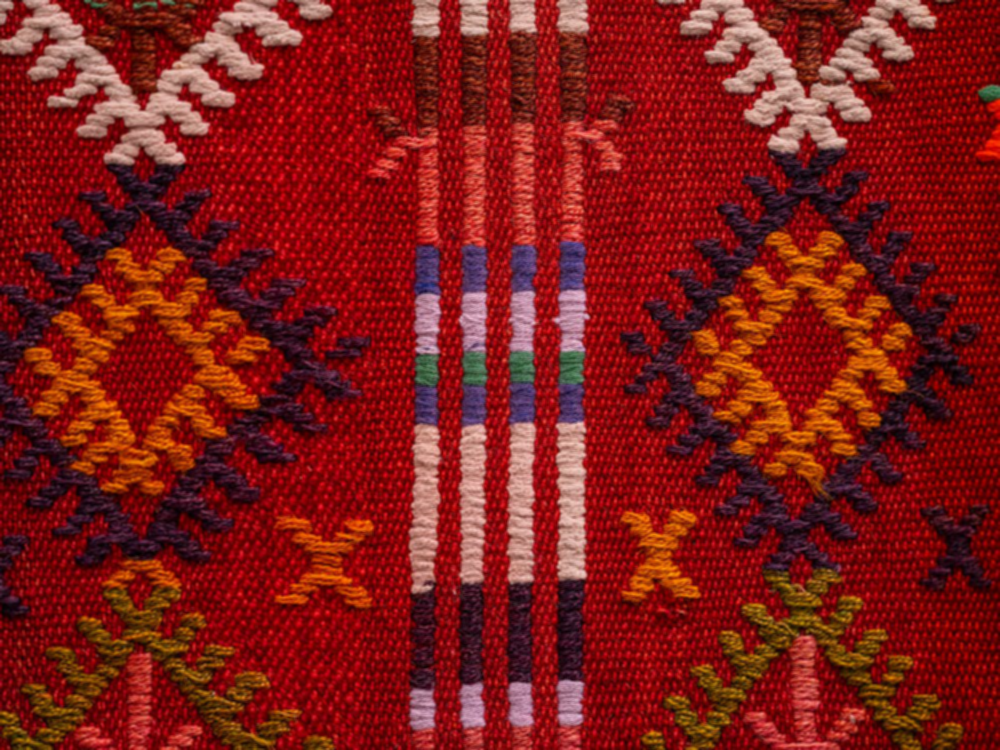

In [ ]:
# Display the input and output images
from IPython.display import Image, display

# print("Input image:")
# display(Image(filename='input.png'))

print("Output image:")
display(Image(filename='output.png'))